In [1]:
#PIC-SURE
import PicSureClient
import PicSureHpdsLib
#STATS
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import statistics as stat
from scipy.stats import ttest_1samp
import tokenManager
import re

fig_size = matplotlib.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
fig_size[0] = 14
fig_size[1] = 8
matplotlib.rcParams["figure.figsize"] = fig_size

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
hemF_string = 'HemoglobinF_percent'
hemS_string = 'HemoglobinS_percent'

In [3]:
def getTermList(srch):
    terms = resource.dictionary().find(srch)
    term_list = terms.keys()
    term_list.sort()
    i = 0
    print("-------------------------")
    print("List for", srch)
    print("-------------------------")
    for term in term_list:
        print(i, " | ", term)
        i += 1
    return term_list 

def createNewPaths(df):
    newPaths = []
    cols = df.columns.values[1:]
    for col in cols:        
        comps = col.split('\\')
        newPath = comps[-2] if '. ' not in comps[-2] else comps[-2].rsplit('. ')[1]
        #idx = [i for i, item in enumerate(comps) if re.search('^S\d+\w*', item)][0]
        #comps4NewPath = comps[2:idx]
        #for comp in comps4NewPath:
        #    newPath += '\\' + comp 
        newPaths.append(newPath)
    return newPaths

def printColumnsIndex(df):
    i = 0
    for col in df.columns:
        print(i," | ",col)
        i += 1

def recodeAge(age):
        if float(age) <= 5:
            return "5 and under"
        else:
            if float(age) >= 15:
                return "15 and over"
            else:
                return "between 5 and 15"

def recodeHgbLevels(hgbLevel):
        if float(hgbLevel) <= 2.0:
            return "Normal"
        else:
            if float(hgbLevel) >= 15:
                return "Extremely High"
            else:
                return "High"
            
def processValuesInColumn(column):
    accHemFV = []
    for item in column:
        total, mean = 0.0, 0.0
        if ';' in item:
            values = item.split(';')
            for val in values:
                total += float(val)
            mean = total/len(values)
        else:
            mean = float(item)
        accHemFV.append(mean)
    return accHemFV

In [4]:
PICSURE_network_URL = <picsure-scd-url>
resource_id = <resource_id>
token_name = "token.txt"
__token__ = tokenManager.importToken(token_name)


[_Security_Token_Imported_Correctly_]


In [5]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, __token__)
adapter = PicSureHpdsLib.Adapter(connection)
#adapter.list()
resource = adapter.useResource(resource_id)

In [6]:
genderTerms = getTermList('00 - Demographics\Gender')
ageTerms = getTermList('00 - Demographics\Age at inclusion')
hemoglobin_sTerms = getTermList('percent of type s hemoglobin')
hemoglobin_fTerms = getTermList('percent of type f hemoglobin')

-------------------------
List for 00 - Demographics\Gender
-------------------------
0  |  \SIT - Cure Sickle Cell\00 - Demographics\Gender\
-------------------------
List for 00 - Demographics\Age at inclusion
-------------------------
0  |  \SIT - Cure Sickle Cell\00 - Demographics\Age at inclusion\
-------------------------
List for percent of type s hemoglobin
-------------------------
0  |  \SIT - Cure Sickle Cell\01 - Arm 4: Screening\01 - Screening\01 - Demographics and phenotypes\S02r0 Demographic And Phenotypic Information (s02r0_demographic_and_phenotypic_information)\05 - Sickle cell\47A. Percent of Type S hemoglobin (xx %):\
1  |  \SIT - Cure Sickle Cell\01 - Arm 4: Screening\01 - Screening\01 - Demographics and phenotypes\S02r1 Demographic And Phenotypic Information (s02r1_demographic_and_phenotypic_information)\05 - Sickle cell\47A. Percent of Type S hemoglobin (xx %):\
2  |  \SIT - Cure Sickle Cell\01 - Arm 4: Screening\02 - Re-screening 1\S02r1 Demographic And Phenotyp

In [7]:
query = resource.query()
query.select().add(hemoglobin_sTerms)
query.select().add(hemoglobin_fTerms)
query.select().add(genderTerms)
query.select().add(ageTerms)

In [8]:
df = query.getResultsDataFrame()
cols = createNewPaths(df) #Eliminate components in the path that are irrelevant
df.columns.values[1:] = cols
df.columns

Index(['Patient ID', 'Age at inclusion', 'Gender',
       'Percent of Type S hemoglobin (xx %):',
       'Percent of Type F hemoglobin (xx %):',
       'Percent of Type S hemoglobin (xx %):',
       'Percent of Type F hemoglobin (xx %):',
       'Percent of Type S hemoglobin (xx %):',
       'Percent of Type F hemoglobin (xx %):',
       'Percent of Type S hemoglobin (xx %):',
       'Percent of Type F hemoglobin (xx %):',
       'Percent of Type S hemoglobin (xx %):',
       'Percent of Type F hemoglobin (xx %):'],
      dtype='object')

In [9]:
def sjoin(x) : return ';'.join(x[x.notnull()].astype(str))
cdf = df.groupby(level=0, axis=1).apply(lambda x : x.apply(sjoin, axis=1))
cdf.columns

Index(['Age at inclusion', 'Gender', 'Patient ID',
       'Percent of Type F hemoglobin (xx %):',
       'Percent of Type S hemoglobin (xx %):'],
      dtype='object')

In [10]:
cols = cdf.columns.values
cols[0] = 'Age'
cols[3] = hemF_string
cols[4] = hemS_string
cdf.columns = cols

In [11]:
acdf = cdf[(cdf[hemS_string] != '') & (cdf['Age'] != '') & (cdf['Gender'] != '') & 
          (cdf[hemF_string] != '')]

In [12]:
acdf[hemS_string] = processValuesInColumn(acdf[hemS_string])
acdf[hemF_string] = processValuesInColumn(acdf[hemF_string])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
acdf['AgeCategories'] = acdf.Age.apply(recodeAge)
acdf['HemoglobinF_Levels'] = acdf.HemoglobinF_percent.apply(recodeHgbLevels)
acdf['HemoglobinS_Levels'] = acdf.HemoglobinS_percent.apply(recodeHgbLevels)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [14]:
acm_df = acdf[(acdf['Gender'] == 'Male') & (acdf['AgeCategories'] == 'between 5 and 15')]
acf_df = acdf[(acdf['Gender'] == 'Female') & (acdf['AgeCategories'] == 'between 5 and 15')]
acm_abb_df = acm_df[['Patient ID', 'HemoglobinF_Levels', 'HemoglobinS_Levels']]
acf_abb_df = acf_df[['Patient ID', 'HemoglobinF_Levels', 'HemoglobinS_Levels']]
acm_abb_df.tail()

,Patient ID,HemoglobinF_Levels,HemoglobinS_Levels
11,P4,High,Extremely High
14,P7,Extremely High,Extremely High
18,P1,Normal,Extremely High
16,P9,High,Extremely High
19,P2,High,Extremely High


In [15]:
acm_hgbf_df = pd.DataFrame(acm_abb_df.groupby('HemoglobinF_Levels').HemoglobinF_Levels.count())
acm_hgbf_df['Percent'] = (acm_hgbf_df.HemoglobinF_Levels / acm_hgbf_df.HemoglobinF_Levels.sum())*100
acf_hgbf_df = pd.DataFrame(acf_abb_df.groupby('HemoglobinF_Levels').HemoglobinF_Levels.count())
acf_hgbf_df['Percent'] = (acf_hgbf_df.HemoglobinF_Levels / acf_hgbf_df.HemoglobinF_Levels.sum())*100

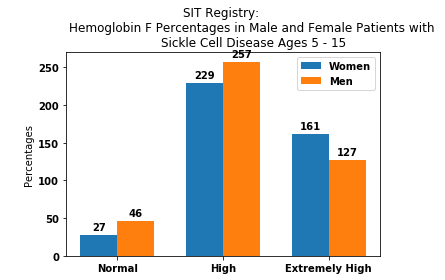

In [16]:
labels = ['Normal', 'High', 'Extremely High']
x = np.arange(len(labels))
hf_women = list(acf_hgbf_df.loc[['Normal', 'High', 'Extremely High']]['HemoglobinF_Levels'])
hf_men = list(acm_hgbf_df.loc[['Normal', 'High', 'Extremely High']]['HemoglobinF_Levels'])
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hf_women, width, label='Women') 
rects2 = ax.bar(x + width/2, hf_men, width, label='Men')

ax.set_ylabel('Percentages')
ax.set_title('''SIT Registry: 
                Hemoglobin F Percentages in Male and Female Patients with 
                Sickle Cell Disease Ages 5 - 15''')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [17]:
hgbf_percentages = list(acdf[acdf['AgeCategories'] == 'between 5 and 15'][hemF_string])
mu = 1.4 #Population values range from 0.8 to 2. We take mu to be the average of these extremes
tset, pval = ttest_1samp(hgbf_percentages, mu)
print("p-value:", pval)

p-value: 3.066257301013124e-143
